In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import sklearn as sk
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import os
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence

from keras.preprocessing.text import Tokenizer
from keras.models import load_model

Using TensorFlow backend.


In [2]:
filenames = ["data/reviews_Home_and_Kitchen_5.json"]
filename = "data/reviews_Home_and_Kitchen_5.json"
t = Tokenizer()
max_features = 20000
maxlen = 100
batch_size = 32

dictionary_size = 0
embed_dim = 300
num_hidden_unit_lstm = 300
num_filter = 100
window_size = 3
pool_size = 2
batch_size = 10
learning_rate = 0.1
dropout_embed = 0.5
dropout_blstm = 0.2
dropout_penultimate = 0.4
l2_lambda = 0.000001

randomShuffle = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)

### Data Preprocessing

In [4]:
def getXY(filename, num_class):
    data = pd.read_json(filename, lines=True, orient="frame")
    data['overall'] = np.where(data['overall'] < 3, 0, data.overall)
    data['overall'] = np.where(data['overall'] > 3, 1, data.overall)
    
    # down sample
    data_0 = data.loc[data['overall'] == 0]
    data_0 = data_0.sample(frac=0.4)
    data_1 = data.loc[data['overall'] == 1].sample(len(data_0))
    
    data = data_0.append(data_1).sample(frac=1)
    
    good_columns = [3]
    onehot_encoder = OneHotEncoder(sparse=False)
    data_X = data.iloc[:, good_columns]
    data_Y = data.iloc[:, 2]
    
    reviewTextList = data.reviewText.values
    t.fit_on_texts(reviewTextList)

    text = t.texts_to_matrix(reviewTextList, mode='count')
    
    data_X = text
    data_Y = np_utils.to_categorical(data_Y, num_class)
    return data_X, data_Y, text.shape[1]

In [28]:
def SVMModel(num_class, input_dim, x_train, x_test, y_train, y_test, batch_size, epochs, name_model):
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)
#     print("x_train:",x_train[0])
#     print("x_test:",x_test[0])
#     print('y_train:',y_train[0])
#     print('y_test',y_test[0])
    model = Sequential()
    model.add(Dense(2,input_dim=input_dim,activation='softmax'))
    print(model.summary())
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    history=model.fit(x_train,y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test,y_test),
                      )
    score=model.evaluate(x_test,y_test)
    print('Test loss:',score[0])
    print('Test accuracy:',score[1])
    plt.figure('categorical_accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Categorical Accuracy')
    plt.plot(history.history['categorical_accuracy'])
    plt.show()
    y_test=np.argmax(y_test,axis=1)
    y_pred=model.predict_classes(x_test)
    print(classification_report(y_test,y_pred))
    
    model.save(name_model)
    del model

In [6]:
num_class = 2
# X, Y, input_dim = getXY(filename, num_class)

-----------------------------
data/reviews_Home_and_Kitchen_5.json:
input dimension:  44816
x_train:  (32908, 44816)
y_train:  (32908, 2)
x_test:  (8228, 44816)
y_test:  (8228, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 89634     
Total params: 89,634
Trainable params: 89,634
Non-trainable params: 0
_________________________________________________________________
None
Train on 32908 samples, validate on 8228 samples
Epoch 1/10
32908/32908 [==============================] - 75s 2ms/step - loss: 0.3814 - categorical_accuracy: 0.8590 - val_loss: 0.3335 - val_categorical_accuracy: 0.8798
Epoch 2/10
32908/32908 [==============================] - 42s 1ms/step - loss: 0.2529 - categorical_accuracy: 0.9094 - val_loss: 0.3090 - val_categorical_accuracy: 0.8836
Epoch 3/10
32908/32908 [==============================] - 50s 2ms/step - loss: 0.2122 - ca

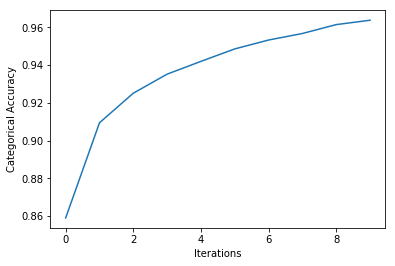

             precision    recall  f1-score   support

          0       0.88      0.86      0.87      4130
          1       0.86      0.88      0.87      4098

avg / total       0.87      0.87      0.87      8228



In [6]:
for filename in filenames:
    print("-----------------------------")
    print(filename + ":")
    X, Y, input_dim = getXY(filename, num_class)
    print("input dimension: ", input_dim)
    for train_index, test_index in randomShuffle.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index, :]
        X_test = X[test_index]
        Y_test = Y[test_index, :]
        
        SVMModel(num_class, input_dim, X_train, X_test, Y_train, Y_test, 10, 10, 'SVM.H5')

In [7]:
model = load_model('SVM.h5')

In [3]:
cat = [0, 1, 2]
def cat_y(y):
    if y<=2.0:
        return cat[0]
    elif y>=4.0:
        return cat[2]
    else:
        return cat[1]

def get_reviews(path, n_samples):
    dt = {}
    i=0
    with open(path) as f:
        for d in f.readlines():
            dt[i] = eval(d)
            i += 1
    df = pd.DataFrame.from_dict(dt, orient='index')[['reviewText','overall']]
    df = df[df['reviewText'].apply(lambda x: len(x.split())>=45)]
    df['bucket'] = df['overall'].apply(cat_y)
    
    df = df.groupby('bucket').apply(lambda x: x.sample(n=n_samples))
    return df

data = get_reviews('data/reviews_Home_and_Kitchen_5.json', 10000)
pd.set_option('display.max_colwidth', -1)
data.sample(3)

reviewText  \
bucket                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2      394890  J.A. Henckels arguably make the best knives available on the mass market.  This set of plastic-handled paring knives is obviously not the highest quality that Henckels offers.  However, the value is extraordinary (about four dollars per knife). After all, if you buy an ultra-cheap paring knife at the grocery store, you're likely to pay just as much.  Furthermore, you can afford to replace the set if they wear out after awhile.  I actually bought my set at a local high-end cookware store: for twice as much!I've had my set for about 6 months and they've held up well.  They're dishwasher safe and clean easily - I haven't had any problems with rusting or staining.  The four knives have different blades, but I've found all of them to be useful for most quick cutting and paring jobs.  They're also attractive - what more can you ask?  Most highly recommended.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
1      28394   To be honest, I only bought this because I kept seeing how expensive waffle cones were at the ice cream shop and thought, I bet I could make it for cheaper.  Apparently, I need a machine to do it right.  Who really, really needs a waffle cone maker anyway?  It was a little on the pricey side but then I divided it out and it comes out to be about 20 waffle cones at the ice cream shop. In those terms, I thought, "Wow, cheap!" However, if I wasn't so fixated on the ice cream shop's waffle cones, then maybe I would have thought, "Really? $50 for a waffle cone maker? Not."But, I succumbed to my weakness and bought the unit. Overall, it's OK. The only trick is trying to control the temperature of the unit. The unit doesn't have a temperature control where you can really set it precisely. It's a sort of hiss-or-miss thing. I made an entire rainbow of waffle cones from dark chocolate color al

In [26]:
def getXY(filename, num_class):   
    cat = [0, 1]
    def cat_y(y):
        if y<=2.0:
            return cat[0]
        elif y>=4.0:
            return cat[1]

    def get_reviews(path, n_samples):
        dt = {}
        i=0
        with open(path) as f:
            for d in f.readlines():
                dt[i] = eval(d)
                i += 1
        df = pd.DataFrame.from_dict(dt, orient='index')[['reviewText','overall']]
        print("before: ", len(df))
        df = df.drop(df[df.overall == 3.0].index)
        print("after: ", len(df))
        df = df[df['reviewText'].apply(lambda x: len(x.split())>=45)]
        df['bucket'] = df['overall'].apply(cat_y)

        df = df.groupby('bucket').apply(lambda x: x.sample(n=n_samples))
        return df

    data = get_reviews('data/reviews_Home_and_Kitchen_5.json', 10000)
    
    good_columns = [3]
    onehot_encoder = OneHotEncoder(sparse=False)
    data_X = data.iloc[:, 0]
    data_Y = data.iloc[:, 2]
    
    reviewTextList = data.reviewText.values
    t.fit_on_texts(reviewTextList)

    text = t.texts_to_matrix(reviewTextList, mode='count')
    
    data_X = text
    data_Y = np_utils.to_categorical(data_Y, num_class)
    return data_X, data_Y, text.shape[1]

-----------------------------
data/reviews_Home_and_Kitchen_5.json:
before:  551682
after:  506623
input dimension:  66145
x_train:  (16000, 66145)
y_train:  (16000, 2)
x_test:  (4000, 66145)
y_test:  (4000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 132292    
Total params: 132,292
Trainable params: 132,292
Non-trainable params: 0
_________________________________________________________________
None
Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 50s 3ms/step - loss: 0.4215 - categorical_accuracy: 0.8376 - val_loss: 0.3314 - val_categorical_accuracy: 0.8762
Epoch 2/10
16000/16000 [==============================] - 29s 2ms/step - loss: 0.2601 - categorical_accuracy: 0.9098 - val_loss: 0.3129 - val_categorical_accuracy: 0.8755
Epoch 3/10
16000/16000 [==============================] -

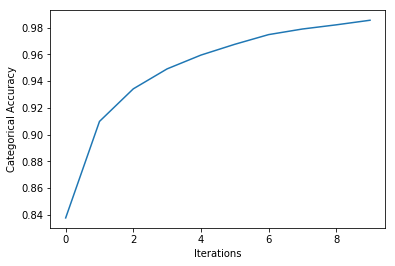

             precision    recall  f1-score   support

          0       0.86      0.84      0.85      1994
          1       0.85      0.87      0.86      2006

avg / total       0.86      0.86      0.86      4000



In [30]:
num_class = 2
for filename in filenames:
    print("-----------------------------")
    print(filename + ":")
    X, Y, input_dim = getXY(filename, num_class)
    print("input dimension: ", input_dim)
    for train_index, test_index in randomShuffle.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index, :]
        X_test = X[test_index]
        Y_test = Y[test_index, :]
        
        SVMModel(num_class, input_dim, X_train, X_test, Y_train, Y_test, 10, 10, 'SVM.H5')

In [31]:
### The upper only 20000 cases